## Assumptions
Transaction cost <br>
Total Cost: 0.05% on large portfolio

Frazzini, Andrea and Israel, Ronen and Moskowitz, Tobias J., Trading Costs (April 7, 2018). Available at SSRN: https://ssrn.com/abstract=3229719 or http://dx.doi.org/10.2139/ssrn.3229719

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')

# # import matplotlib
# # matplotlib.style.use('classic')
# # sns.set_style("whitegrid")
# # %matplotlib inline

pd.set_option('display.max_columns', None)
import sys

In [2]:
positions = pd.read_csv("../../Predictions/Metalearner/25_tickers_prediction.csv")
positions.Date = pd.to_datetime(positions.Date, dayfirst=False)

# Create extra column of long only returns
positions["long_only"] = 1

# Need to read in prices
prices = pd.read_csv("../../Raw Data/Price/price_labels.csv")
prices["Date"] = pd.to_datetime(prices["Date"], dayfirst=False)
# We use adjusted close. This accounts for dividends stock splits (if we're holding and we get dividends, this
# will be reflected in the adj close)
prices = prices.pivot(columns="Ticker", index="Date", values="Adj Close")
returns = np.log(prices).diff() # log returns so that we can add

# Index and columns same as positions 
returns = returns[returns.columns[returns.columns.isin(positions.Ticker.unique())]]
returns = returns.loc[positions.Date.unique()]
col_order = returns.columns

In [3]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

#### Obtain scoring metrics across different predictions

In [4]:
performance_results = pd.DataFrame()
for pred_type in ['Predictions_8k', 'Predictions_10kq', 'Predictions_tweets', 'Predictions_news', 'ensemble_pred', 
              'xgb_pred', 'logreg_pred', 'RF_pred', 'long_only']:
    preds = positions[~(positions[pred_type] == 0)][pred_type]
    y_actual = positions[~(positions[pred_type] == 0)].Label
    performance_results[pred_type] = [
        accuracy_score(y_actual, preds),
        f1_score(y_actual, preds),
        recall_score(y_actual, preds),
        precision_score(y_actual, preds)
    ]

Text(0.5, 1.0, 'Performance Metrics')

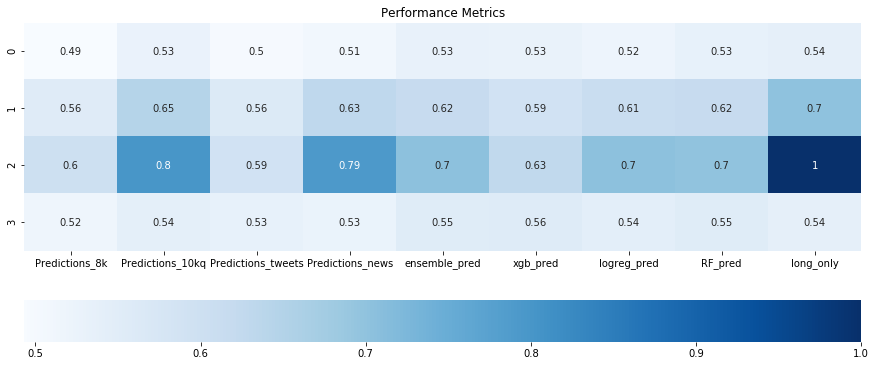

In [5]:
plt.figure(figsize=(15,6))
sns.heatmap(performance_results, cmap="Blues", annot=True, cbar_kws = dict(use_gridspec=False,location="bottom"))
plt.title("Performance Metrics")

# Preprocess Data to obtain model returns

#### Pivot positions to get time series of positions of companies by date

In [6]:
sec_8k        = positions.pivot(columns="Ticker", index="Date", values="Predictions_8k")[col_order]
sec_10k10q    = positions.pivot(columns="Ticker", index="Date", values="Predictions_10kq")[col_order]
tweets        = positions.pivot(columns="Ticker", index="Date", values="Predictions_tweets")[col_order]
news          = positions.pivot(columns="Ticker", index="Date", values="Predictions_news")[col_order]
meta_ensemble = positions.pivot(columns="Ticker", index="Date", values="ensemble_pred")[col_order]
meta_xgb      = positions.pivot(columns="Ticker", index="Date", values="xgb_pred")[col_order]
meta_logreg   = positions.pivot(columns="Ticker", index="Date", values="logreg_pred")[col_order]
meta_rf       = positions.pivot(columns="Ticker", index="Date", values="RF_pred")[col_order]
long_only     = positions.pivot(columns="Ticker", index="Date", values="long_only")[col_order]
perfect_pred  = positions.pivot(columns="Ticker", index="Date", values="Label")[col_order]

In [7]:
sec_8k.head()

Ticker,AAPL,AXP,BA,CSCO,CVX,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,UNH,UTX,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-04,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-05,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-08,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-09,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,1,0


#### Get Apple Only Returns For Comparison with Amazon Augmented Datasets

In [8]:
positions = pd.concat([sec_8k.AAPL, sec_10k10q.AAPL, tweets.AAPL, news.AAPL, meta_ensemble.AAPL, 
  meta_xgb.AAPL, meta_logreg.AAPL, meta_rf.AAPL, long_only.AAPL, perfect_pred.AAPL], axis=1)
aapl_rtns = positions * returns[["AAPL"]]
aapl_rtns.columns = ["sec_8k", "sec_10k10q", "tweets","news", "meta_ensemble", "meta_xgb","meta_logreg", "meta_rf", "long_only", "perfect_pred"]

In [9]:
aapl_rtns.to_csv("../../Predictions/Metalearner/appl_no_amzn.csv")

#### Scale all values, absolute sum of all values should = 1

In [10]:
epsilon = sys.float_info.epsilon
epsilon # for adding small values

2.220446049250313e-16

In [11]:
sec_8k        = sec_8k.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
sec_10k10q    = sec_10k10q.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
tweets        = tweets.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
news          = news.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
meta_ensemble = meta_ensemble.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
meta_xgb      = meta_xgb.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
meta_logreg   = meta_logreg.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
meta_rf       = meta_rf.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
long_only     = long_only.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)
perfect_pred  = perfect_pred.apply(lambda x: x/sum(abs(x)+epsilon), axis = 1)

In [12]:
sec_8k.head()

Ticker,AAPL,AXP,BA,CSCO,CVX,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,UNH,UTX,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
2018-01-04,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
2018-01-05,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
2018-01-08,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
2018-01-09,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.25,0.0


### Pre-TC Model Returns Calculation

In [13]:
sec_8k_pretc        = sec_8k * returns # no tc subtracted
sec_10k10q_pretc    = sec_10k10q * returns
tweets_pretc        = tweets * returns
news_pretc          = news * returns
meta_ensemble_pretc = meta_ensemble * returns
meta_xgb_pretc      = meta_xgb * returns
meta_logreg_pretc   = meta_logreg * returns
meta_rf_pretc       = meta_rf * returns
long_only_pretc     = long_only * returns
perfect_pred_pretc  = perfect_pred * returns

#### Sum up row-wise to obtain model returns

In [14]:
sec_8k_pretc        = sec_8k_pretc.apply(lambda x: sum(x), axis = 1)
sec_10k10q_pretc    = sec_10k10q_pretc.apply(lambda x: sum(x), axis = 1)
tweets_pretc        = tweets_pretc.apply(lambda x: sum(x), axis = 1)
news_pretc          = news_pretc.apply(lambda x: sum(x), axis = 1)
meta_ensemble_pretc = meta_ensemble_pretc.apply(lambda x: sum(x), axis = 1)
meta_xgb_pretc      = meta_xgb_pretc.apply(lambda x: sum(x), axis = 1)
meta_logreg_pretc   = meta_logreg_pretc.apply(lambda x: sum(x), axis = 1)
meta_rf_pretc       = meta_rf_pretc.apply(lambda x: sum(x), axis = 1)
long_only_pretc     = long_only_pretc.apply(lambda x: sum(x), axis = 1)
perfect_pred_pretc  = perfect_pred_pretc.apply(lambda x: sum(x), axis = 1)

In [15]:
data = {"sec_8k":sec_8k_pretc,
"sec_10k10q":sec_10k10q_pretc,
"tweets":tweets_pretc,
"news":news_pretc,
"meta_ensemble":meta_ensemble_pretc,
"meta_xgb":meta_xgb_pretc,
"meta_logreg":meta_logreg_pretc,
"meta_rf":meta_rf_pretc,
"long_only":long_only_pretc,
"perfect_pred":perfect_pred_pretc}
model_returns_pretc = pd.DataFrame(data).iloc[1:]
model_returns_pretc.head()

,sec_8k,sec_10k10q,tweets,news,meta_ensemble,meta_xgb,meta_logreg,meta_rf,long_only,perfect_pred
Date,,,,,,,,,,
2018-01-04,0.001136,0.004934,0.002180,-0.018509,0.002081,0.002562,0.000812,0.002168,0.005545,0.007635
2018-01-05,0.004359,0.004635,0.004391,0.006953,-0.004096,-0.002168,-0.004291,-0.003212,0.006823,0.008228
2018-01-08,-0.005359,0.000091,-0.002296,0.004030,0.000721,0.001202,-0.000587,0.000149,0.000174,0.005907
2018-01-09,-0.005195,0.000559,0.000653,-0.001022,-0.000986,0.001613,-0.003582,0.000185,0.000754,0.006960
2018-01-10,-0.008177,-0.000051,-0.001946,-0.000661,0.000743,0.000761,-0.002016,0.000202,-0.000608,0.005238


### Post-TC Model Returns Calculation

#### Get transaction cost

In [16]:
sec_8k_tc        = abs(sec_8k.diff())        * 0.05 / 100
sec_10k10q_tc    = abs(sec_10k10q.diff())    * 0.05 / 100
tweets_tc        = abs(tweets.diff())        * 0.05 / 100
news_tc          = abs(news.diff())          * 0.05 / 100
meta_ensemble_tc = abs(meta_ensemble.diff()) * 0.05 / 100
meta_xgb_tc      = abs(meta_xgb.diff())      * 0.05 / 100
meta_logreg_tc   = abs(meta_logreg.diff())   * 0.05 / 100
meta_rf_tc       = abs(meta_rf.diff())       * 0.05 / 100
long_only_tc     = abs(long_only.diff())     * 0.05 / 100
perfect_pred_tc  = abs(perfect_pred.diff())  * 0.05 / 100

In [17]:
sec_8k        = sec_8k * returns - sec_8k_tc
sec_10k10q    = sec_10k10q * returns - sec_10k10q_tc
tweets        = tweets * returns - tweets_tc
news          = news * returns - news_tc
meta_ensemble = meta_ensemble * returns - meta_ensemble_tc
meta_xgb      = meta_xgb * returns - meta_xgb_tc
meta_logreg   = meta_logreg * returns - meta_logreg_tc
meta_rf       = meta_rf * returns - meta_rf_tc
long_only     = long_only * returns - long_only_tc
perfect_pred  = perfect_pred * returns - perfect_pred_tc

In [18]:
sec_8k.head()

Ticker,AAPL,AXP,BA,CSCO,CVX,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,UNH,UTX,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.0,0.007998,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.007362,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2018-01-05,0.0,0.001139,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.003220,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,0.000000,-0.0
2018-01-08,-0.0,-0.004622,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.000738,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.000000,-0.0,0.0,0.0,-0.0,0.000000,0.0
2018-01-09,-0.0,0.000797,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.001389,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.001958,0.0,0.0,-0.0,-0.0,-0.003145,-0.0


#### Lastly, sum up all the returns from different assets to obtain model returns

In [19]:
sec_8k        = sec_8k.apply(lambda x: sum(x), axis = 1)
sec_10k10q    = sec_10k10q.apply(lambda x: sum(x), axis = 1)
tweets        = tweets.apply(lambda x: sum(x), axis = 1)
news          = news.apply(lambda x: sum(x), axis = 1)
meta_ensemble = meta_ensemble.apply(lambda x: sum(x), axis = 1)
meta_xgb      = meta_xgb.apply(lambda x: sum(x), axis = 1)
meta_logreg   = meta_logreg.apply(lambda x: sum(x), axis = 1)
meta_rf       = meta_rf.apply(lambda x: sum(x), axis = 1)
long_only     = long_only.apply(lambda x: sum(x), axis = 1)
perfect_pred  = perfect_pred.apply(lambda x: sum(x), axis = 1)

In [20]:
sec_8k.head()

Date
2018-01-03         NaN
2018-01-04    0.000636
2018-01-05    0.004359
2018-01-08   -0.005359
2018-01-09   -0.005695
dtype: float64

In [21]:
data = {"sec_8k":sec_8k,
"sec_10k10q":sec_10k10q,
"tweets":tweets,
"news":news,
"meta_ensemble":meta_ensemble,
"meta_xgb":meta_xgb,
"meta_logreg":meta_logreg,
"meta_rf":meta_rf,
"long_only":long_only,
"perfect_pred":perfect_pred}
model_returns = pd.DataFrame(data).iloc[1:]
model_returns.head()

,sec_8k,sec_10k10q,tweets,news,meta_ensemble,meta_xgb,meta_logreg,meta_rf,long_only,perfect_pred
Date,,,,,,,,,,
2018-01-04,0.000636,0.004934,0.001860,-0.019009,0.001841,0.002202,0.000692,0.001808,0.005545,0.007195
2018-01-05,0.004359,0.004635,0.004231,0.006953,-0.004416,-0.002608,-0.004451,-0.003692,0.006823,0.007828
2018-01-08,-0.005359,0.000091,-0.002536,0.003030,0.000561,0.000962,-0.000707,-0.000211,0.000174,0.005507
2018-01-09,-0.005695,0.000559,0.000373,-0.001522,-0.001306,0.001173,-0.003782,-0.000175,0.000754,0.006320
2018-01-10,-0.008427,-0.000051,-0.002066,-0.000661,0.000583,0.000401,-0.002096,-0.000078,-0.000608,0.004838


# Visualisations with Perfect Prediction

Text(0, 0.5, 'Annualised Sharpe Ratio')

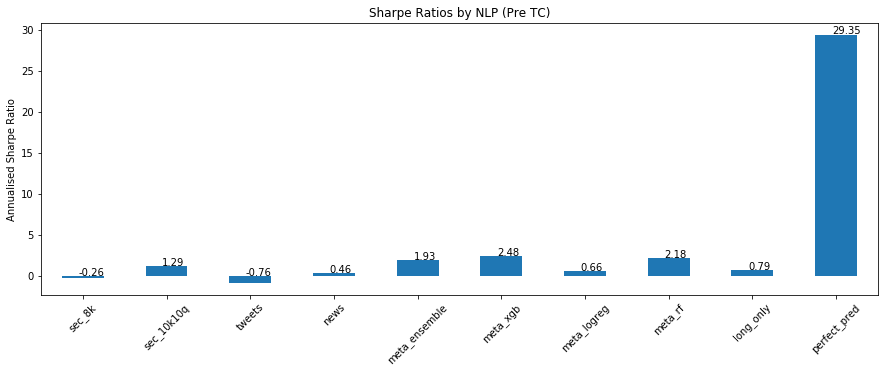

In [22]:
sharpe_ratios = round(model_returns_pretc.mean() / model_returns_pretc.std() * 252 ** 0.5, 2)
ax = sharpe_ratios.plot(kind="bar", rot=45, figsize=(15,5))

for p in ax.patches:
    if p.get_height() <= 0:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.05, 0.01))
    else:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.05, p.get_height() * 1.005))
plt.title("Sharpe Ratios by NLP (Pre TC)")
plt.ylabel("Annualised Sharpe Ratio")

Text(0, 0.5, 'Annualised Sharpe Ratio')

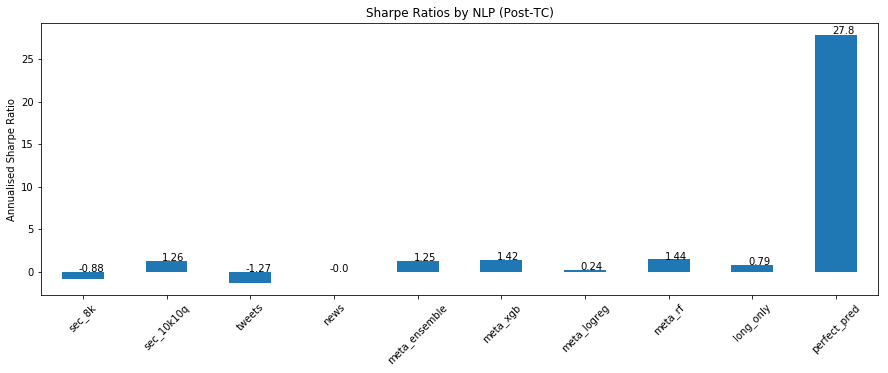

In [23]:
sharpe_ratios = round(model_returns.mean() / model_returns.std() * 252 ** 0.5, 2)
ax = sharpe_ratios.plot(kind="bar", rot=45, figsize=(15,5))

for p in ax.patches:
    if p.get_height() <= 0:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.05, 0.01))
    else:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.05, p.get_height() * 1.005))
plt.title("Sharpe Ratios by NLP (Post-TC)")
plt.ylabel("Annualised Sharpe Ratio")

Text(0.5, 1.0, 'Model Returns (Pre-TC)')

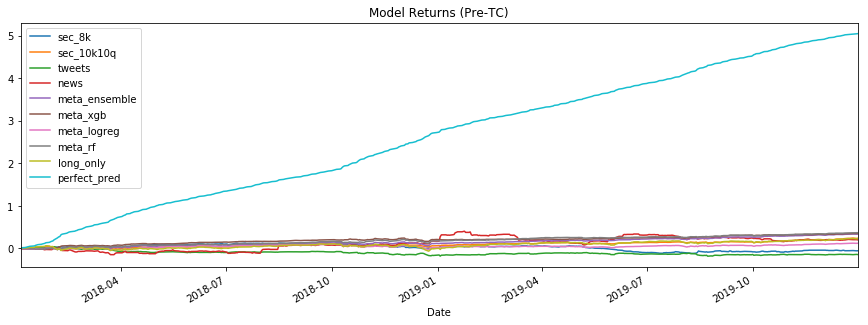

In [24]:
model_returns_pretc.expanding(2).sum().plot(figsize=(15,5))
plt.title("Model Returns (Pre-TC)")

Text(0.5, 1.0, 'Model Returns (Post-TC)')

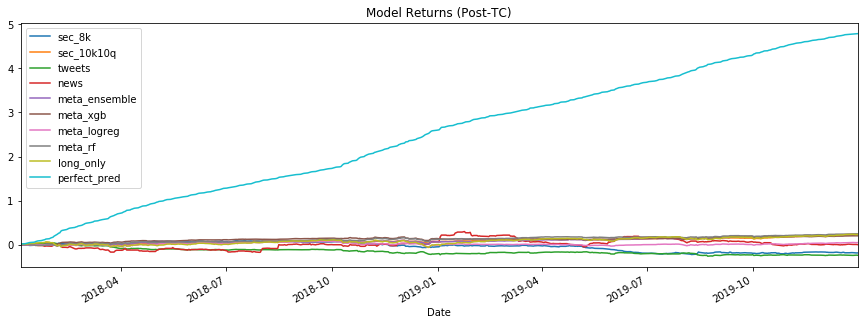

In [25]:
model_returns.expanding(2).sum().plot(figsize=(15,5))
plt.title("Model Returns (Post-TC)")

Text(0.5, 0, 'Prediction Type')

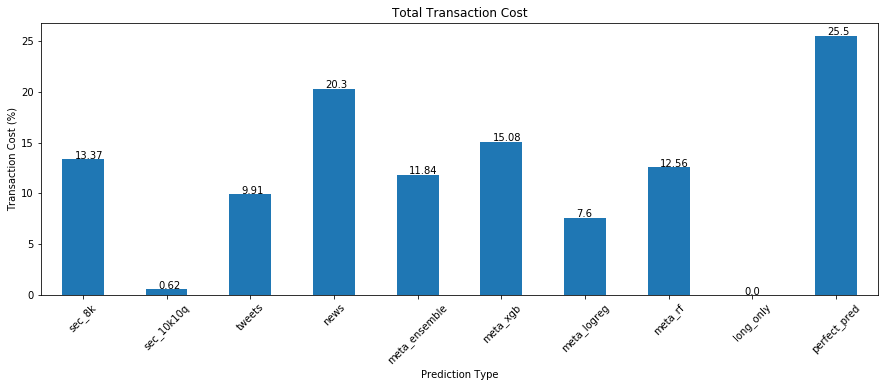

In [26]:
transaction_cost = round((model_returns_pretc.expanding(2).sum().iloc[-1] - model_returns.expanding(2).sum().iloc[-1]) * 100, 2)
ax = transaction_cost.plot(kind="bar", figsize=(15, 5), rot=45)

for p in ax.patches:
    if p.get_height() <= 0:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.1, 0.01))
    else:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.1, p.get_height() * 1.005))
plt.title("Total Transaction Cost")
plt.ylabel("Transaction Cost (%)")
plt.xlabel("Prediction Type")

# Visualisations

In [27]:
plot_cols = ['sec_8k', 'sec_10k10q', 'tweets', 'news', 'meta_ensemble', 'meta_xgb', 'meta_logreg', 'meta_rf', 'long_only']

Text(0.5, 1.0, 'Model Returns (Pre-TC)')

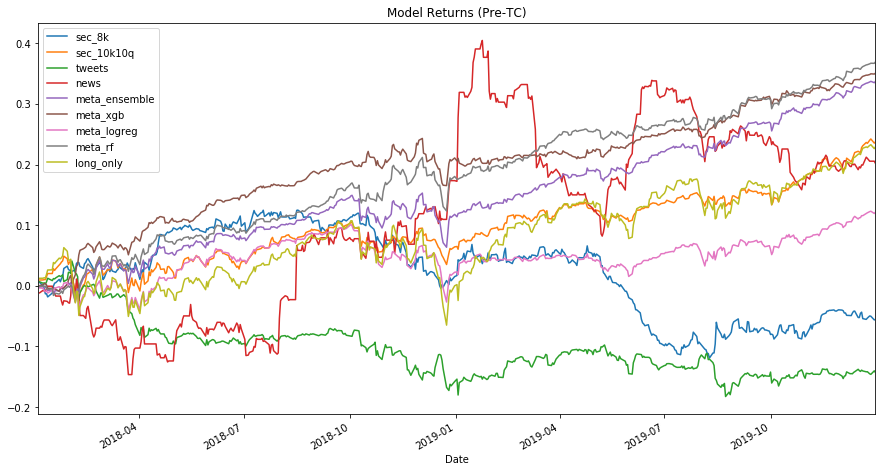

In [28]:
model_returns_pretc[plot_cols].expanding(2).sum().plot(figsize=(15,8))
plt.title("Model Returns (Pre-TC)")

In [29]:
plot_cols

['sec_8k',
 'sec_10k10q',
 'tweets',
 'news',
 'meta_ensemble',
 'meta_xgb',
 'meta_logreg',
 'meta_rf',
 'long_only']

Text(0.5, 1.0, 'Model Returns (Post-TC)')

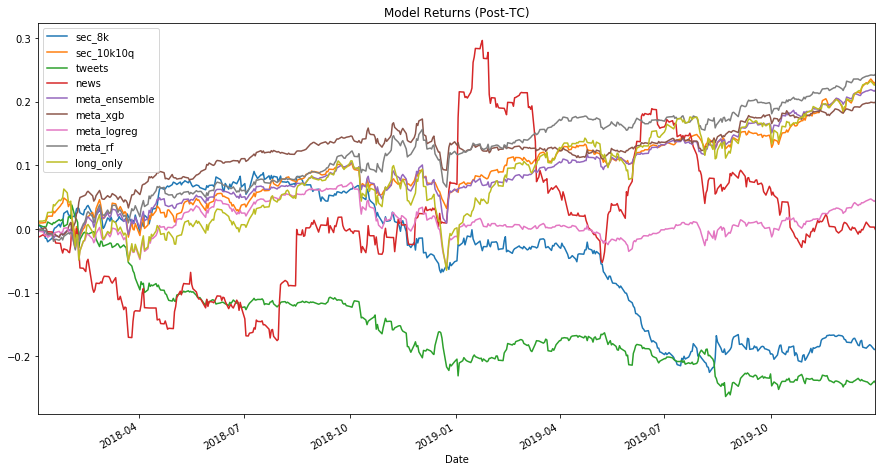

In [30]:
model_returns[plot_cols].expanding(2).sum().plot(figsize=(15,8))
plt.title("Model Returns (Post-TC)")

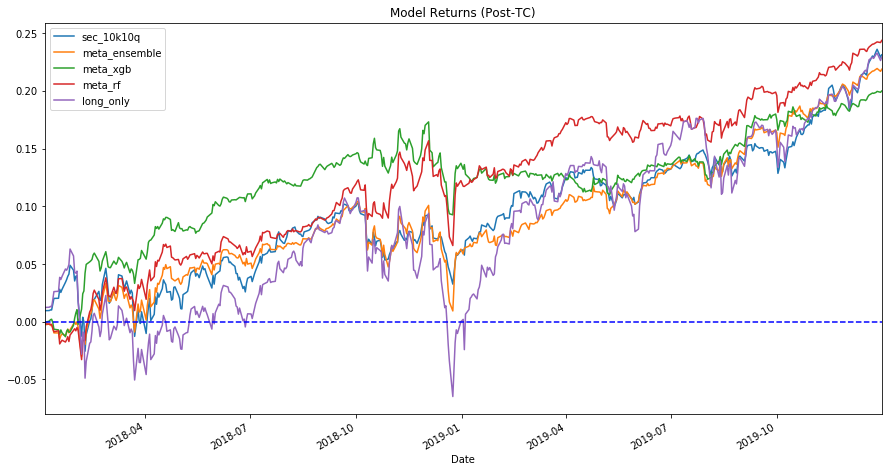

In [31]:
model_returns[['sec_10k10q',
 'meta_ensemble',
 'meta_xgb',
 'meta_rf',
 'long_only']].expanding(2).sum().plot(figsize=(15,8))
plt.title("Model Returns (Post-TC)")
plt.axhline(0, color='blue', ls="--")

Text(0.5, 0, 'Prediction Type')

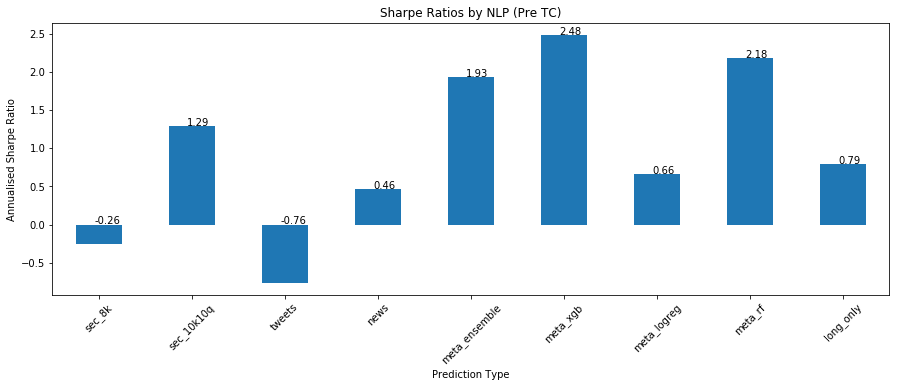

In [32]:
sharpe_ratios = round(model_returns_pretc[plot_cols].mean() / model_returns_pretc[plot_cols].std() * 252 ** 0.5, 2)
ax = sharpe_ratios.plot(kind="bar", rot=45, figsize=(15,5))

for p in ax.patches:
    if p.get_height() <= 0:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.05, 0.01))
    else:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.05, p.get_height() * 1.005))
plt.title("Sharpe Ratios by NLP (Pre TC)")
plt.ylabel("Annualised Sharpe Ratio")
plt.xlabel("Prediction Type")

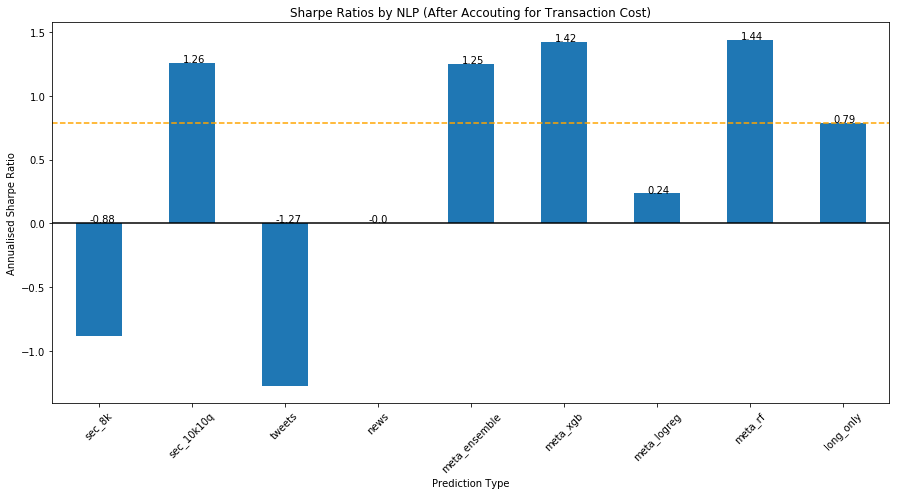

In [33]:
sharpe_ratios = round(model_returns[plot_cols].mean() / model_returns[plot_cols].std() * 252 ** 0.5, 2)
ax = sharpe_ratios.plot(kind="bar", rot=45, figsize=(15,7))

for p in ax.patches:
    if p.get_height() <= 0:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.1, 0.01))
    else:
        ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2-0.1, p.get_height() * 1.005))
plt.title("Sharpe Ratios by NLP (After Accouting for Transaction Cost)")
plt.ylabel("Annualised Sharpe Ratio")
plt.xlabel("Prediction Type")
plt.axhline(0, color='black')
plt.axhline(0.79, color='orange', ls="--")

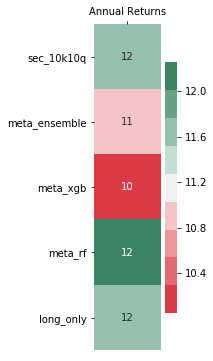

In [34]:
returns = model_returns[['sec_10k10q', 'meta_ensemble', 'meta_xgb', 'meta_rf', 'long_only']].expanding(2).sum().iloc[-1] / 501 * 252
annual_rtns = round(pd.DataFrame(returns) * 100, 2)
annual_rtns.columns = ["Annual Returns"]
plt.figure(figsize=(1.5,6))
ax = sns.heatmap(annual_rtns, cmap = sns.diverging_palette(10, 150, n=9), annot=True)
ax.xaxis.set_ticks_position('top')

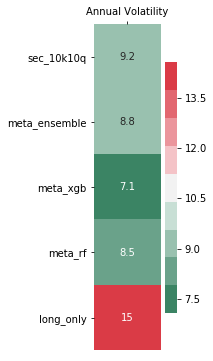

In [35]:
vol = pd.DataFrame(round(model_returns[['sec_10k10q', 'meta_ensemble', 'meta_xgb', 'meta_rf', 'long_only']].std() * 252 ** 0.5 * 100, 2))
vol.columns = ["Annual Volatility"]
plt.figure(figsize=(1.5,6))
ax = sns.heatmap(vol, cmap = sns.diverging_palette(150, 10, n=9), annot=True)
ax.xaxis.set_ticks_position('top')

In [36]:
cumulative_returns = model_returns[['sec_10k10q', 'meta_ensemble', 'meta_xgb', 'meta_rf', 'long_only']].expanding(2).sum()

In [37]:
drawdowns = dict()
for col in cumulative_returns.columns:
    maximum_drawdown = []
    highest = cumulative_returns[col].values[1]
    lowest = cumulative_returns[col].values[1]
    for cum_rtn in cumulative_returns[col].values:
        if cum_rtn >= highest:
            maximum_drawdown.append(highest - lowest)
            highest = cum_rtn
            lowest = cum_rtn
            continue
        if cum_rtn <= lowest:
            lowest = cum_rtn
    drawdowns[col] = [max(maximum_drawdown)]

In [38]:
drawdowns

{'long_only': [0.1721420821425495],
 'meta_ensemble': [0.09522100365564819],
 'meta_rf': [0.09077613127384337],
 'meta_xgb': [0.080526819924972],
 'sec_10k10q': [0.07442998311481788]}

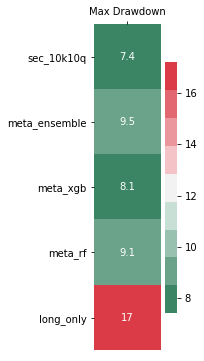

In [39]:
plt.figure(figsize=(1.5,6))
dd_df = round(pd.DataFrame.from_dict(drawdowns).T * 100, 2)
dd_df.columns = ["Max Drawdown"]
ax = sns.heatmap(dd_df, cmap = sns.diverging_palette(150, 10, n=9), annot=True)
ax.xaxis.set_ticks_position('top')